In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GroupShuffleSplit, GroupKFold, train_test_split

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16

In [2]:
df = pd.read_csv("data/cook_county_housing.csv", index_col='Unnamed: 0')

In [3]:
df.shape

(204792, 62)

In [4]:
df.columns
# replacing the space with the "_" in all the columns
df.columns = df.columns.str.replace(" ", "")
df.columns

Index(['PIN', 'PropertyClass', 'NeighborhoodCode', 'LandSquareFeet',
       'TownCode', 'Apartments', 'WallMaterial', 'RoofMaterial', 'Basement',
       'BasementFinish', 'CentralHeating', 'OtherHeating', 'CentralAir',
       'Fireplaces', 'AtticType', 'AtticFinish', 'DesignPlan',
       'CathedralCeiling', 'ConstructionQuality', 'SiteDesirability',
       'Garage1Size', 'Garage1Material', 'Garage1Attachment', 'Garage1Area',
       'Garage2Size', 'Garage2Material', 'Garage2Attachment', 'Garage2Area',
       'Porch', 'OtherImprovements', 'BuildingSquareFeet', 'RepairCondition',
       'MultiCode', 'NumberofCommercialUnits', 'Estimate(Land)',
       'Estimate(Building)', 'DeedNo.', 'SalePrice', 'Longitude', 'Latitude',
       'CensusTract', 'MultiPropertyIndicator', 'ModelingGroup', 'Age', 'Use',
       'O'HareNoise', 'Floodplain', 'RoadProximity', 'SaleYear', 'SaleQuarter',
       'SaleHalf-Year', 'SaleQuarterofYear', 'SaleMonthofYear',
       'SaleHalfofYear', 'MostRecentSale', 'AgeDec

In [5]:
pd.set_option('display.max_rows', len(df.dtypes))
df.dtypes

PIN                           int64
PropertyClass                 int64
NeighborhoodCode              int64
LandSquareFeet              float64
TownCode                      int64
Apartments                  float64
WallMaterial                float64
RoofMaterial                float64
Basement                    float64
BasementFinish              float64
CentralHeating              float64
OtherHeating                float64
CentralAir                  float64
Fireplaces                  float64
AtticType                   float64
AtticFinish                   int64
DesignPlan                  float64
CathedralCeiling            float64
ConstructionQuality         float64
SiteDesirability            float64
Garage1Size                 float64
Garage1Material             float64
Garage1Attachment           float64
Garage1Area                 float64
Garage2Size                 float64
Garage2Material             float64
Garage2Attachment           float64
Garage2Area                 

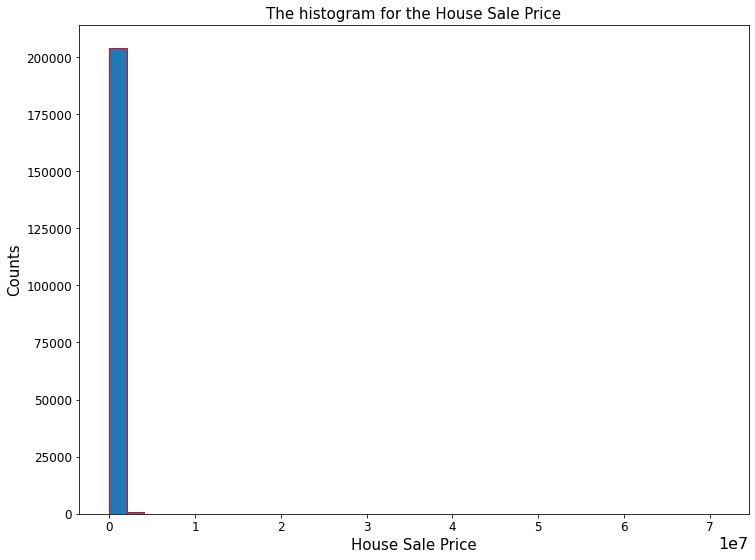

In [6]:
plt.xlabel("House Sale Price", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.title("The histogram for the House Sale Price", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.hist(df.SalePrice, bins = 35, edgecolor = 'red');

## need to do log transformations
df["LogSalePrice"] = np.log(df["SalePrice"])
#plt.hist(df.LogSalePrice, bins = 35, edgecolor = 'red');

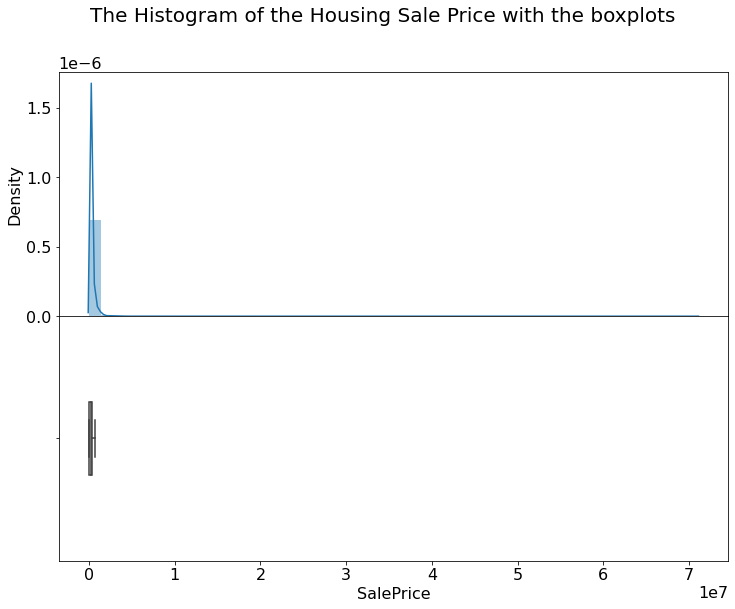

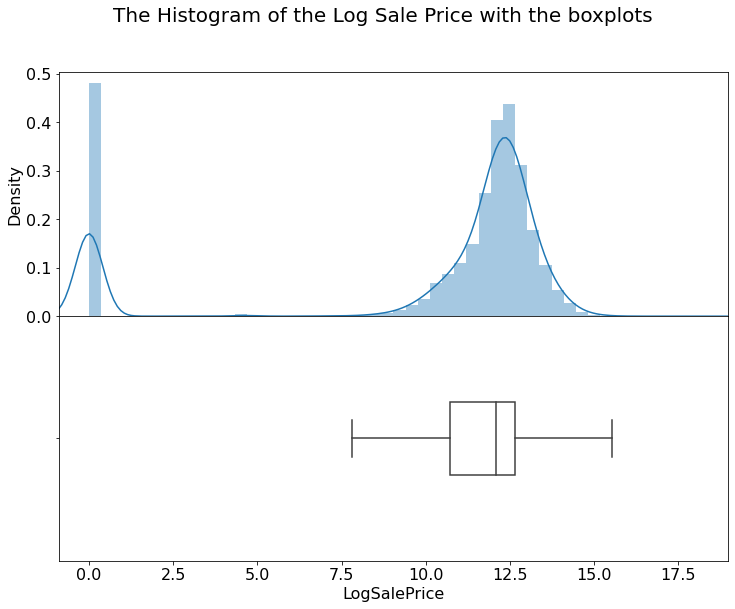

In [7]:
def plot_distribution(data, label, title):
    fig, axs = plt.subplots(nrows=2)
    fig.suptitle(title, fontsize = 20)
    
    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))
    # Put the two plots together
    plt.subplots_adjust(hspace=0)

    # Adjust boxplot fill to be white
    axs[1].artists[0].set_facecolor('white')
    
#figure, axis = plt.subplots(ncols = 2)
#plt.subplots(ncols = 2)
plot_distribution(df, label='SalePrice', title = "The Histogram of the Housing Sale Price with the boxplots")
plt.savefig('figures/beforelog.png')
plot_distribution(df, label='LogSalePrice', title = "The Histogram of the Log Sale Price with the boxplots")
plt.savefig('figures/afterlog.png')

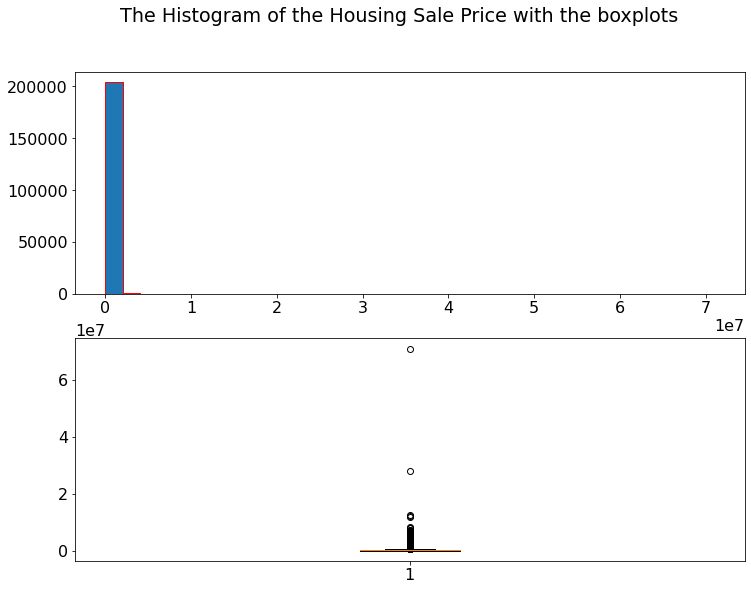

In [8]:
def plot_distribution(data, label, title):
    fig, axs = plt.subplots(nrows=2)
    #sns.set(rc = {'figure.figsize':(10,7)}, font_scale = 1)
    fig.suptitle(title)
    axs[0].hist(df[label], bins= 35, edgecolor = 'red');
    axs[1].boxplot(df[label])
plot_distribution(df, label='SalePrice', title = "The Histogram of the Housing Sale Price with the boxplots")
#plt.savefig('save_as_a_png.png')

In [15]:
def draw_bar(df, col):
    print(df[col].value_counts())
    tctostr = [str(i) for i in df[col].value_counts().keys()]
    plt.bar(tctostr, df[col].value_counts(), color = 'maroon')

In [16]:
categorical_ftr = ["PropertyClass", "NeighborhoodCode", "TownCode", "Apartments", "WallMaterial", "RoofMaterial",
                  "Basement", "BasementFinish", "CentralHeating", "OtherHeating", "CentralAir", "Fireplaces", "AtticType","AtticFinish",
                  "DesignPlan", "CathedralCeiling", "ConstructionQuality", "SiteDesirability", "Garage1Material", 
                  "Garage1Attachment","Garage1Area", "Garage2Material","Garage2Attachment", "Garage2Area", "Porch", "OtherImprovements",
                  "RepairCondition", "MultiCode", "NumberofCommercialUnits", "CensusTract", "MultiPropertyIndicator",
                  "ModelingGroup", "Use", "O\'HareNoise", "Floodplain", "RoadProximity", "MostRecentSale", "PureMarketFilter",
                  "GarageIndicator", "NeigborhoodCode(mapping)", "TownandNeighborhood"]

non_analysis = ["PIN", "Description", "DeedNo."]
cont_ftr = df.columns[(~df.columns.isin(categorical_ftr)) & (~df.columns.isin(non_analysis))].to_list()

len(categorical_ftr) + len(non_analysis) + len(cont_ftr) == len(df.columns)

True

In [17]:
df.MostRecentSale

0         1.0
1         1.0
2         0.0
3         1.0
4         0.0
         ... 
204787    0.0
204788    1.0
204789    1.0
204790    1.0
204791    0.0
Name: MostRecentSale, Length: 204792, dtype: float64

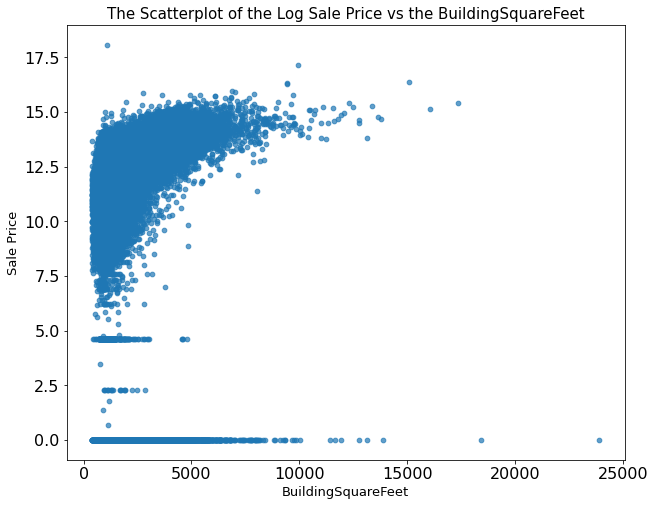

In [18]:
plt.figure(figsize = (10,8))
plt.scatter(df["BuildingSquareFeet"], df.LogSalePrice, s = 22, alpha = 0.7)
plt.xlabel("BuildingSquareFeet", fontsize = 13)
plt.ylabel("Sale Price", fontsize = 13)
plt.title("The Scatterplot of the Log Sale Price vs the BuildingSquareFeet", fontsize= 15);

In [19]:
for ftr in categorical_ftr:
    draw_bar(df, ftr)

203    94359
202    33571
278    24250
205    19855
204    12369
207     8115
206     7990
208     2972
209     1311
Name: PropertyClass, dtype: int64
30     10649
80      8547
10      7383
70      6914
50      6357
       ...  
134        9
99         7
145        5
341        1
106        1
Name: NeighborhoodCode, Length: 193, dtype: int64
72    31493
71    24218
70    11416
37     9387
31     9071
77     7218
38     7104
39     6882
22     6008
13     5699
21     5596
18     5164
29     5158
25     5067
20     5047
32     4985
12     4883
35     4858
23     4703
24     4504
73     3815
28     3790
16     3375
11     2975
27     2819
17     2373
36     2227
15     2202
30     1947
26     1817
76     1697
10     1355
19     1347
75     1216
34     1189
33      766
74      735
14      686
Name: TownCode, dtype: int64
0.0    204783
5.0         7
6.0         2
Name: Apartments, dtype: int64
2.0    87026
1.0    71308
3.0    41988
4.0     4470
Name: WallMaterial, dtype: int64
1.0    194810

KeyboardInterrupt: 

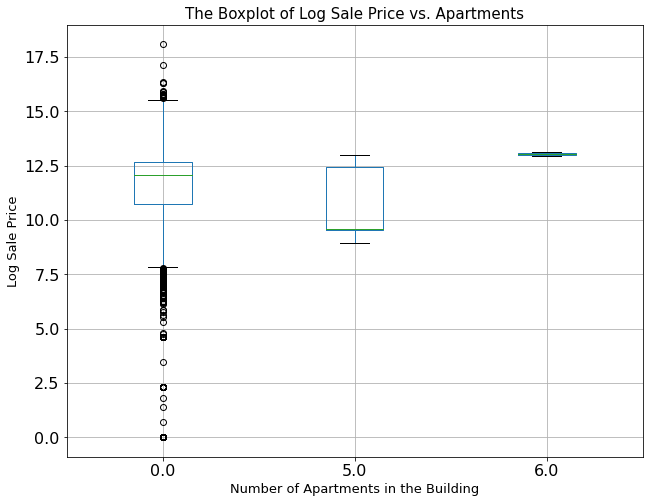

In [20]:
bed_with_y = df[["Apartments", "LogSalePrice"]]
bed_with_y.boxplot(figsize=(10, 8), by = "Apartments");
plt.xlabel("Number of Apartments in the Building", fontsize = 13);
plt.ylabel("Log Sale Price", fontsize = 13);
plt.suptitle('')
plt.title("The Boxplot of Log Sale Price vs. Apartments", fontsize = 15);
plt.savefig('figures/logspandapt.png')

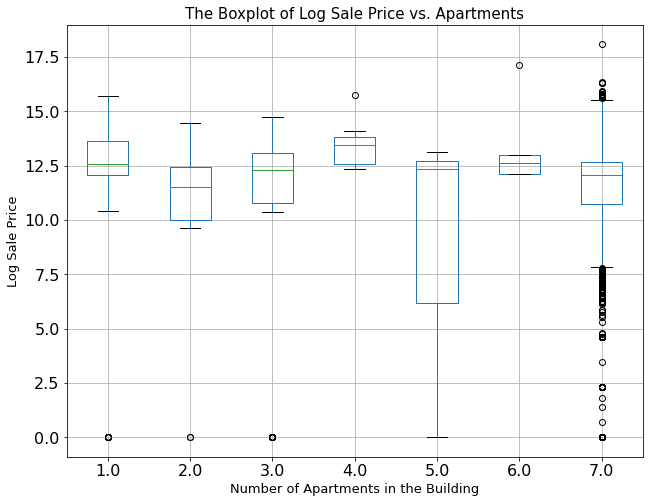

In [21]:
bed_with_y = df[["Garage2Size", "LogSalePrice"]]
bed_with_y.boxplot(figsize=(10, 8), by = "Garage2Size");
plt.xlabel("Number of Apartments in the Building", fontsize = 13);
plt.ylabel("Log Sale Price", fontsize = 13);
plt.suptitle('')
plt.title("The Boxplot of Log Sale Price vs. Apartments", fontsize = 15);
plt.savefig('figures/logspandapt.png')

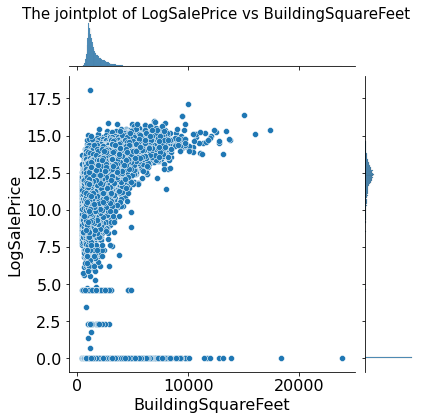

In [22]:
before_log = sns.jointplot(data = df, x = "BuildingSquareFeet", y = "LogSalePrice", ratio = 5)
before_log.fig.suptitle("The jointplot of LogSalePrice vs BuildingSquareFeet", fontsize = 15);
plt.savefig('figures/logspbsf.png')

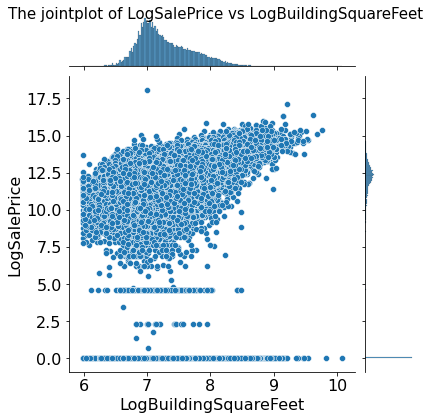

In [23]:
df["LogBuildingSquareFeet"] = np.log(df["BuildingSquareFeet"])
after_log = sns.jointplot(data = df, x = "LogBuildingSquareFeet", y = "LogSalePrice", ratio = 5)
after_log.fig.suptitle("The jointplot of LogSalePrice vs LogBuildingSquareFeet", fontsize = 15);
plt.savefig('figures/logspandlogapt.png')

In [ ]:
def auto_visual(df, y_name):
    col_names_noy = df.columns[df.columns != y_name]
    for col in col_names_noy:
        if ((df[col].dtype == "O") or 
            (df[col].dtype == "int64" and 
             df[col].nunique() <= 15 and
             df[df[col]!=0][col].nunique()/df[df[col] != 0][col].count() < 0.05)):
            this_df = df[[col, y_name]]
            this_df.boxplot(figsize = (8, 8), by = col)
            plt.suptitle("The plot is Grouped by %a" %col, fontsize = 15)
            plt.title("Sale Price vs. %a" %col, fontsize = 12)
            plt.xticks(rotation = 45)
            plt.xlabel(col, fontsize = 13)
            plt.ylabel(y_name, fontsize = 13)
            plt.show()
        else:
            plt.figure(figsize = (8,8))
            plt.scatter(df[col], df[y_name], s = 22, alpha = 0.7)
            plt.title("Sale Price vs. %a" %col, fontsize = 15)
            plt.xlabel(col, fontsize = 13)
            plt.ylabel(y_name, fontsize = 13)
            plt.show()

auto_visual(df, "LogSalePrice")

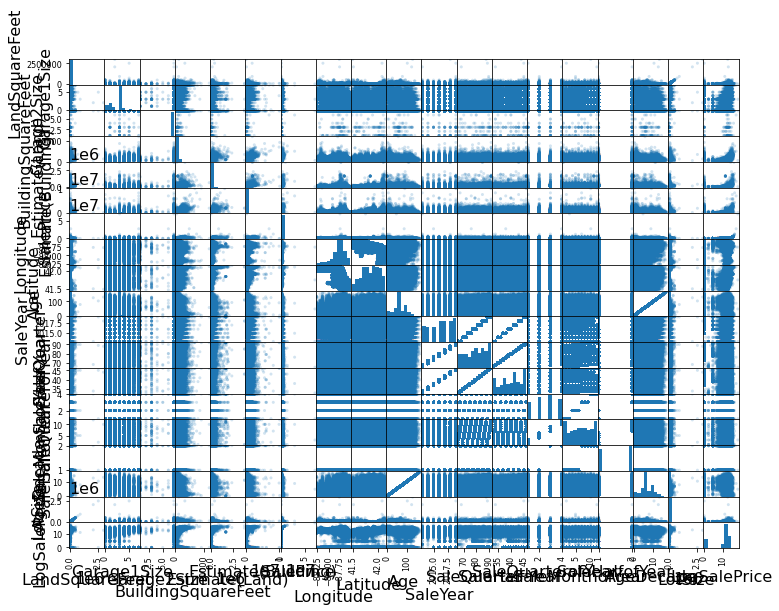

In [27]:
pd.plotting.scatter_matrix(df[cont_ftr], alpha = 0.2);


In [28]:
df["Grp_LogSalePrice"] = np.zeros(df.shape[0])
df["Grp_LogSalePrice"][df["LogSalePrice"]<2.5] = "lessthan2.5"
df["Grp_LogSalePrice"][(df["LogSalePrice"]>=2.5) & (df["LogSalePrice"]<7.5)] = "between2.5and7.5"
df["Grp_LogSalePrice"][df["LogSalePrice"]>=7.5] = "over7.5"

In [30]:
# Use stratified splitting
from collections import Counter
y_forsplitting = df[["Grp_LogSalePrice"]]
X_forsplitting = df.loc[:, ((df.columns != "SalePrice") & (df.columns != "LogSalePrice"))]


def stratified_fcn(X, y, train_size, val_size, test_size, strati_tar, random_seed, num_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size= test_size, random_state = random_seed, stratify = strati_tar)
    second_split = StratifiedKFold(n_splits=num_folds, shuffle = True, random_state=random_seed)
    ind_needed = X_other.index
    new_strat = strati_tar[ind_needed]
    total = {"X_train":[], "y_train":[], "X_val":[], "y_val":[], "X_test":[], "y_test":[]}
    for train_ind, val_ind in second_split.split(X_other, y_other, groups=new_strat):
        X_train = X_other.iloc[train_ind]
        y_train = y_other.iloc[train_ind]
        X_val = X_other.iloc[val_ind]
        y_val = y_other.iloc[val_ind]
        total["X_val"].append(X_val)
        total["y_val"].append(y_val)
        total["X_train"].append(X_train)
        total["y_train"].append(y_train)
    total["X_test"].append(X_test)
    total["y_test"].append(y_test) 
    return total


splitting = stratified_fcn(X_forsplitting, y_forsplitting, 0.8, 0.1, 0.1, df["Grp_LogSalePrice"], 44, 5) 



X = df.loc[:, ((df.columns != "SalePrice") & (df.columns != "LogSalePrice") & (df.columns != "Grp_LogSalePrice"))]
y = df[["LogSalePrice"]]

def getting_split(df_set):
    training_index = [i.index.to_list() for i in df_set["X_train"]]
    validation_index = [i.index.to_list() for i in df_set["X_val"]]
    testing_index = [i.index.to_list() for i in df_set["X_test"]]
    for i in range(0, len(training_index)):
        #globals()["X_training_fold_" + str(i)] = X.iloc[training_index[i]]
        #globals()["X_validation_fold_" + str(i)] = X.iloc[validation_index[i]]
        #globals()["y_training_fold_" + str(i)] = y.iloc[training_index[i]]
        #globals()["y_validation_fold_" + str(i)] = y.iloc[validation_index[i]]
        globals()["fold_" + str(i)] = {"X_training": X.iloc[training_index[i]], "y_training": y.iloc[training_index[i]], 
                                       "X_validation": X.iloc[validation_index[i]], "y_validation": y.iloc[validation_index[i]],
                                       "X_testing": X.iloc[testing_index[0]], "y_testing": y.iloc[testing_index[0]]}
    return {"fold_1": fold_0, "fold_2": fold_1, "fold_3": fold_2, "fold_4": fold_3, "fold_5": fold_4}


folds = getting_split(splitting)

In [31]:
len(Counter(splitting["X_train"][0].index.to_list() + splitting["X_test"][0].index.to_list() + splitting["X_val"][0].index.to_list()).keys()) == df.shape[0]

True

In [32]:
maxmin_ftr = ["Garage1Size", 'Garage2Size', 'Longitude','Latitude', "MultiCode"]
std_ftr = ['LandSquareFeet','BuildingSquareFeet', 'Garage2Size','Estimate(Land)','Estimate(Building)', 'Age', 'SaleYear', 
           'SaleQuarter', 'SaleHalf-Year', 'SaleQuarterofYear', 'SaleMonthofYear', 'AgeDecade', 'LotSize','LogBuildingSquareFeet']
no_need = ['PIN', 'DeedNo.', 'Description', 'SalePrice', 'LogSalePrice','CensusTract']
ord_ftr = ["Basement", "BasementFinish","CentralAir", "Fireplaces", "AtticType", "AtticFinish","DesignPlan", 
          "CathedralCeiling", "ConstructionQuality", "SiteDesirability", "Garage1Attachment", "Garage1Area", 
          "Garage2Attachment", "Garage2Area", "RepairCondition", "NumberofCommercialUnits", "Floodplain", 
          "GarageIndicator"]
onehot_ftr = ["PropertyClass","NeighborhoodCode", "TownCode", "Apartments" ,"WallMaterial", "RoofMaterial", 
             "CentralHeating", "OtherHeating","Garage1Material", "Garage2Material", "Porch", "OtherImprovements", 
             "MultiPropertyIndicator", "ModelingGroup", "Use", "O'HareNoise", "RoadProximity", "SaleHalfofYear",
              "MostRecentSale", "PureMarketFilter", "NeigborhoodCode(mapping)", "TownandNeighborhood"] + ord_ftr

ord_cat = [[4.0, 3.0, 2.0, 1.0], [3.0, 1.0], [1.0,0.0], [0.0, 1.0, 2.0], [3.0, 2.0, 1.0], [0, 3, 1], [0.0, 2.0, 1.0],
          [0.0,2.0, 1.0], [3.0, 2.0, 1.0], [3.0, 2.0, 1.0], [0.0, 2.0, 1.0], [0.0, 2.0, 1.0], [0.0, 2.0, 1.0], 
          [0.0, 4.0, 2.0, 1.0], [3.0, 2.0, 1.0], [0.0, 1.0, 2.0, 5.0], [1.0, 0.0], [1.0, 0.0]]
#check = maxmin_ftr+std_ftr+no_need+ord_ftr+onehot_ftr
#set(check)-set(df.columns.to_list()) == set()

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftr),
        ('minmax', MinMaxScaler(), maxmin_ftr),
        ('std', StandardScaler(), std_ftr)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here

X_train_prep = clf.fit_transform(folds["fold_1"]["X_training"])
X_val_prep = clf.transform(folds["fold_1"]["X_validation"])
X_test_prep = clf.transform(folds["fold_1"]["X_testing"])

#print(X_train.shape)
#print(X_train_prep.shape)
#print(X_train_prep)
X_train_prep[0:5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.92741141e+00,  7.48577394e-01,  2.41828412e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -4.46589571e-01, -5.84478250e-02, -7.58292029e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.54859652e+00,  8.16213793e-01,  1.45886016e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         7.24292816e-01, -2.50596687e-01, -1.85031418e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -4.81027288e-01, -1.57176201e-03, -1.07146461e-01]])